In [1]:
import numpy as np
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d, interp2d, RectBivariateSpline, LinearNDInterpolator, NearestNDInterpolator
import concurrent.futures
import matplotlib.pyplot as plt
import pickle, tqdm, functools
import vegas
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})


## Definitions and EdS case

In [2]:
with open('/home/fverdian/class/soundspeed-scripts/1loop/Pk-lin-int.pkl', 'rb') as f:
    Plin_int = pickle.load(f)
fact=(2*np.pi)**3

def F3(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    kPq2 = k2 + q2 + 2*k*q*mu 

    res1 = 1/kMq2*(5/126*k2-11/108*k*q*mu+7/108*q2*mu2-1/54*k2*k2*mu2/q2+4/189*k2*k*mu2*mu/q-23/756*k2*k*mu/q+25/252*k2*mu2-2/27*k*q*mu2*mu)
    res2 = 1/kPq2*(5/126*k2+11/108*k*q*mu-7/108*q2*mu2-4/27*k2*k2*mu2/q2-53/189*k2*k*mu2*mu/q+23/756*k2*k*mu/q-121/756*k2*mu2-5/27*k*q*mu2*mu)
    return res1+res2

def F2(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    return (k2*(7*k*q*mu+3*q2)-10*k2*q2*mu2)/(14*q2*kMq2)

def alpha(k1,k2,cT):
    return 1+cT*k2/k1

def alphas(k1,k2,cT):
    return 1+0.5*cT*(k2/k1+k1/k2)

def beta(k1,k2,cT):
    t1=k1*k1+k2*k2+2*k1*k2*cT
    t2=k1*k2*cT
    t3=2.*k1*k1*k2*k2
    return t1*t2/t3


In [4]:
# kevList=np.logspace(np.log10(1.e-2),np.log10(10),200)
kevList=np.logspace(np.log10(0.05),np.log10(1),50)
# kevList=[0.15]
reslist=[]
def P1loop_EdS_int(vars,kev):
    q=vars[0]
    mu=vars[1]
    P13=6*q*q*F3(kev,q,mu)*Plin_int(q)*Plin_int(kev)
    kMq = np.sqrt(kev*kev + q*q - 2*kev*q*mu)
    kPq = np.sqrt(kev*kev + q*q + 2*kev*q*mu)
    P22=0
    if kMq>q:
        P22+=2*q*q*F2(kev,q,mu)*F2(kev,q,mu)*Plin_int(q)*Plin_int(kMq)
    if kPq>q:
        P22+=2*q*q*F2(kev,q,-mu)*F2(kev,q,-mu)*Plin_int(q)*Plin_int(kPq)
    return (P13+P22)*4*np.pi/fact
integ = vegas.Integrator([[1.e-5, 10], [0, 1.]],mpi=True, nproc=48)

print('Training')
result = integ(functools.partial(P1loop_EdS_int, kev=0.1),neval=10000)
print('Applying')
    
reslist = np.array(list(reslist))
reslist=[]
for kev in kevList:
    result = integ(functools.partial(P1loop_EdS_int, kev=kev),neval=500)
    reslist.append(result.mean)
    print(f'Result at k={kev:.3f} is {result}', end='\r')
reslist=np.array(reslist)

Training
Applying


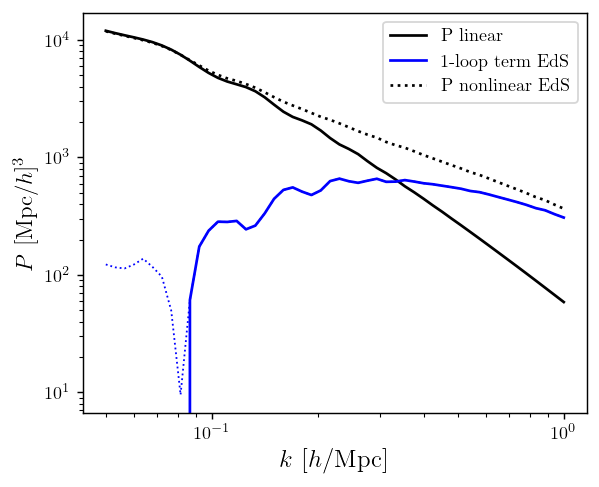

In [5]:
plt.figure(figsize=(5,4), dpi=130)


plt.plot(kevList,Plin_int(kevList),'k',label=r'P linear')

plt.plot(kevList,reslist, 'b',label=r'1-loop term EdS')
plt.plot(kevList,np.abs(reslist), 'b:', linewidth=1)

plt.plot(kevList,Plin_int(kevList)+reslist,'k:',label=r'P nonlinear EdS')


plt.xlabel(r"$k$ [$h/\mathrm{Mpc}$]", fontsize=14)
plt.ylabel(r"$P$ $[\mathrm{Mpc}/h]^3$", fontsize=13)

plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/P-1loop-fx0p1.pdf', bbox_inches='tight')

plt.show()

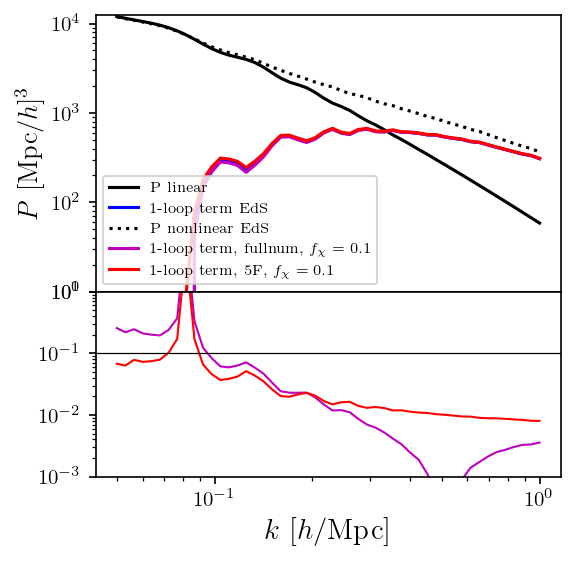

In [5]:
k_hot,onel_diff_hot,EdS_oneloop=np.loadtxt('/home/fverdian/class/soundspeed-scripts/kernels-fullnum/4em/1loop-fullhot-fx0p1.txt', unpack=True)
oneloop_hot = EdS_oneloop + onel_diff_hot


k_with_fx,onel_diff_full=np.loadtxt('/home/fverdian/class/soundspeed-scripts/kernels-fullnum/4em/1loopdiff-kmax10-fx0p1.txt', unpack=True)
oneloop_with_fx=EdS_oneloop+onel_diff_full

fig, axs = plt.subplots(2, 1, sharex=True,gridspec_kw={'height_ratios': [1.5,1]}, figsize=(4,4), dpi=150);plt.subplots_adjust(hspace = 0)
# Upper plot
axs[0].plot(k_with_fx, Plin_int(k_with_fx), 'k', label=r'P linear')
axs[0].plot(k_with_fx, EdS_oneloop, 'b', label=r'1-loop term EdS')
axs[0].plot(k_with_fx, Plin_int(k_with_fx) + EdS_oneloop, 'k:', label=r'P nonlinear EdS')
axs[0].plot(k_with_fx, oneloop_with_fx, 'm', label=r'1-loop term, fullnum, $f_\chi=0.1$')
axs[0].plot(k_hot, oneloop_hot, 'r', label=r'1-loop term, 5F, $f_\chi=0.1$')


axs[0].set_ylabel(r"$P$ $[\mathrm{Mpc}/h]^3$", fontsize=13)
axs[0].set_ylim([10,None])
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend(fontsize=7)

# Lower plot
relative_diff = np.abs(EdS_oneloop - oneloop_with_fx) / np.abs(EdS_oneloop)
axs[1].plot(k_with_fx, relative_diff, 'm', label='Relative Difference', linewidth=1)
relative_diff = np.abs(EdS_oneloop - oneloop_hot) / np.abs(EdS_oneloop)
axs[1].plot(k_hot, relative_diff, 'r', label='Relative Difference', linewidth=1)
axs[1].axhline(0.1,color='k', linewidth=0.6)
plt.xlabel(r"$k$ [$h/\mathrm{Mpc}$]", fontsize=14)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim([0.001,1])

# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/P-1loop-fx0p1.pdf', bbox_inches='tight')

plt.show()

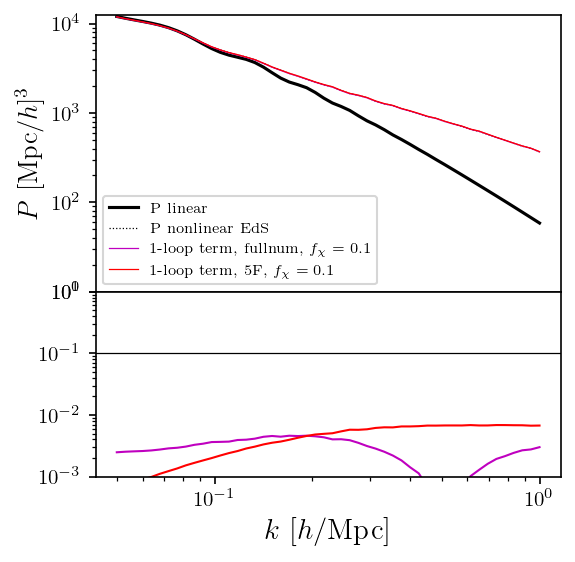

In [10]:
k_hot,onel_diff_hot,EdS_oneloop=np.loadtxt('/home/fverdian/class/soundspeed-scripts/kernels-fullnum/4em/1loop-fullhot-fx0p1.txt', unpack=True)
oneloop_hot = EdS_oneloop + onel_diff_hot


k_with_fx,onel_diff_full=np.loadtxt('/home/fverdian/class/soundspeed-scripts/kernels-fullnum/4em/1loopdiff-kmax10-fx0p1.txt', unpack=True)
oneloop_with_fx=EdS_oneloop+onel_diff_full

fig, axs = plt.subplots(2, 1, sharex=True,gridspec_kw={'height_ratios': [1.5,1]}, figsize=(4,4), dpi=150);plt.subplots_adjust(hspace = 0)
# Upper plot
axs[0].plot(k_with_fx, Plin_int(k_with_fx), 'k', label=r'P linear')
axs[0].plot(k_with_fx, Plin_int(k_with_fx) + EdS_oneloop, 'k:',linewidth=0.6,  label=r'P nonlinear EdS')
axs[0].plot(k_with_fx, Plin_int(k_with_fx)+ oneloop_with_fx, 'm',linewidth=0.6,  label=r'1-loop term, fullnum, $f_\chi=0.1$')
axs[0].plot(k_hot, Plin_int(k_with_fx)+oneloop_hot, 'r',linewidth=0.6,  label=r'1-loop term, 5F, $f_\chi=0.1$')


axs[0].set_ylabel(r"$P$ $[\mathrm{Mpc}/h]^3$", fontsize=13)
axs[0].set_ylim([10,None])
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend(fontsize=7)

# Lower plot
relative_diff = np.abs(EdS_oneloop - oneloop_with_fx) / np.abs(Plin_int(k_with_fx) +EdS_oneloop)
axs[1].plot(k_with_fx, relative_diff, 'm', label='Relative Difference', linewidth=1)
relative_diff = np.abs(EdS_oneloop - oneloop_hot) / np.abs(Plin_int(k_with_fx) +EdS_oneloop)
axs[1].plot(k_hot, relative_diff, 'r', label='Relative Difference', linewidth=1)
axs[1].axhline(0.1,color='k', linewidth=0.6)
plt.xlabel(r"$k$ [$h/\mathrm{Mpc}$]", fontsize=14)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim([0.001,1])
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/P-1loop-fx0p1.pdf', bbox_inches='tight')
plt.show()

---
### Now the true with fx

In [11]:
fx=0.3
fullt=np.linspace(-5,3, 100)
idx_eta=np.abs(fullt - (0.)).argmin()
# I will make the case of kJ=0.1 at a=0.1
kref=0.1

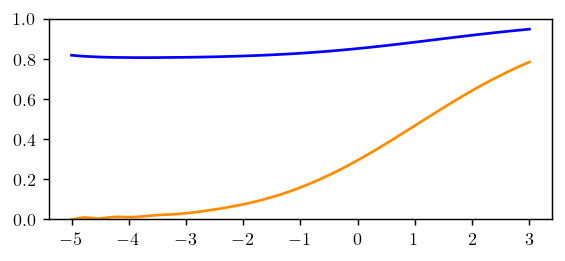

In [12]:
# this is solved fot k=0.1 (for which tildeeta = eta) and then I shift it using the smmetry
def lin_system(w,t):
    dc,Tc,dx,Tx = w
    ddcdt = Tc
    dTcdt = -0.5*Tc+1.5*(1-fx)*dc+1.5*fx*dx
    ddxdt = Tx
    dTxdt = -0.5*Tx+1.5*(1-fx)*dc+1.5*(fx-(1)*np.exp(-t))*dx
    return [ddcdt, dTcdt,ddxdt, dTxdt]
# Initial conditions
w0 = [1,1-3/5*fx,0.,0.]
# Solve the differential equation
tlin=np.linspace(fullt[0],fullt[-1],1000)
linsol = odeint(lin_system, w0, tlin)
g_c_int=interp1d(tlin,linsol[:,1]/linsol[:, 0], fill_value='extrapolate')
phi_x_int=interp1d(tlin,linsol[:, 2]/linsol[:, 0],fill_value='extrapolate')
g_x_int=interp1d(tlin,linsol[:, 3]/linsol[:, 0],fill_value='extrapolate')
plt.figure(figsize=(5,2), dpi=130);plt.ylim([0,1])
plt.plot(fullt, g_c_int(fullt), 'b', label=r'$\Theta$')
plt.plot(fullt, phi_x_int(fullt), 'darkorange', label=r'$\delta_\chi$')
plt.show()

In [20]:
#--------
# 2nd order
#--------
def solve_second_order(triplet, return_timedep=False):
    k1 , k2, cT = triplet
    def F2_system(w, t):
        Fc2,Gc2,Fx2,Gx2 = w
        fact=(g_c_int(t-2*np.log(k1))+g_c_int(t-2*np.log(k2)))

        SF2=0.5*g_c_int(t-2*np.log(k2))*alpha(k1,k2,cT)+0.5*g_c_int(t-2*np.log(k1))*alpha(k2,k1,cT)
        dFc2dt = -fact*Fc2 + Gc2 + SF2
        dGc2dt = -(0.5+fact)*Gc2 + 1.5 *((1-fx)*Fc2+fx*Fx2) +g_c_int(t-2*np.log(k1))*g_c_int(t-2*np.log(k2))*beta(k1,k2,cT)

        SF2=0.5*phi_x_int(t-2*np.log(k1))*g_x_int(t-2*np.log(k2))*alpha(k1,k2,cT)+0.5*phi_x_int(t-2*np.log(k2))*g_x_int(t-2*np.log(k1))*alpha(k2,k1,cT)
        dFx2dt = -fact*Fx2 + Gx2 + SF2
        dGx2dt = -(0.5+fact)*Gx2 + 1.5 *((1-fx)*Fc2+(fx-(k1**2+k2**2+2*k1*k2*cT)/(kref**2)*np.exp(-t))*Fx2) +g_x_int(t-2*np.log(k1))*g_x_int(t-2*np.log(k2))*beta(k1,k2,cT)

        return [dFc2dt, dGc2dt,dFx2dt, dGx2dt]
    Fc2_0=(5./7.+6/245*fx)*alphas(k1,k2,cT)+(2./7.-6/245*fx)*beta(k1,k2,cT)
    Gc2_0=(3./7-51/245*fx)*alphas(k1,k2,cT)+(4./7-96/245*fx)*beta(k1,k2,cT)
    sol = odeint(F2_system, [Fc2_0,Gc2_0,0,0], fullt, rtol=1.e-4)
    if return_timedep:
        return sol
    return sol[idx_eta]

In [17]:
#--------
# 3rd order
#--------
def DeltaF3(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    res1 = 1/kMq2*(-88/945*k2-28/405*k*q*mu+128/2835*k2*k*mu/q+92/567*k2*mu2-128/2835*k2*k*mu2*mu/q)
    res2 = 1/kMq2*(28/405*q*k*mu2*mu-28/405*k2*mu2*mu2)
    return res1+res2

def solve_F3_for_k(triplet, return_timedep=False):
    k , q, mu = triplet
    #Call twice the second order kernels
    ker2_k_mq_full=solve_second_order([k,q,-mu], return_timedep=True)
    ker2_k_q_full=solve_second_order([k,q,mu], return_timedep=True)

    def F3_system(w, t):

        Fc3,Gc3,Fx3,Gx3 = w
        fact=(g_c_int(t-2*np.log(k))+2*g_c_int(t-2*np.log(q)))

        idx_t_F3=np.abs(fullt - t).argmin()
        ker2_k_mq=ker2_k_mq_full[idx_t_F3]
        ker2_k_q=ker2_k_q_full[idx_t_F3]

        #F3_c and G3_c
        kMq = np.sqrt(k*k + q*q - 2*k*q*mu)
        cT=(k*mu-q)/kMq
        SF3=g_c_int(t-2*np.log(q))*alpha(q,kMq,cT)*ker2_k_mq[0]+alpha(kMq,q,cT)*ker2_k_mq[1]
        SG3=g_c_int(t-2*np.log(q))*beta(kMq,q,cT)*2*ker2_k_mq[1]
        kPq = np.sqrt(k*k + q*q + 2*k*q*mu)
        cT=-(k*mu+q)/kPq
        SF3+=g_c_int(t-2*np.log(q))*alpha(q,kPq,cT)*ker2_k_q[0]+alpha(kPq,q,cT)*ker2_k_q[1]
        SG3+=g_c_int(t-2*np.log(q))*beta(kPq,q,cT)*2*ker2_k_q[1]

        dFc3dt = -fact*Fc3 + Gc3 + SF3/3
        dGc3dt = -(0.5+fact)*Gc3 + 1.5*((1-fx)*Fc3+fx*Fx3) + SG3/3

        #F3_c and G3_c
        kMq = np.sqrt(k*k + q*q - 2*k*q*mu)
        cT=(k*mu-q)/kMq
        SF3x=g_x_int(t-2*np.log(q))*alpha(q,kMq,cT)*ker2_k_mq[2]+phi_x_int(t-2*np.log(q))*alpha(kMq,q,cT)*ker2_k_mq[3]
        SG3x=g_x_int(t-2*np.log(q))*beta(kMq,q,cT)*2*ker2_k_mq[3]
        kPq = np.sqrt(k*k + q*q + 2*k*q*mu)
        cT=-(k*mu+q)/kPq
        SF3x+=g_x_int(t-2*np.log(q))*alpha(q,kPq,cT)*ker2_k_q[2]+phi_x_int(t-2*np.log(q))*alpha(kPq,q,cT)*ker2_k_q[3]
        SG3x+=g_x_int(t-2*np.log(q))*beta(kPq,q,cT)*2*ker2_k_q[3]

        dFx3dt = -fact*Fx3 + Gx3 + SF3x/3
        dGx3dt = -(0.5+fact)*Gx3 + 1.5*((1-fx)*Fc3+(fx-(k**2)/(kref**2)*np.exp(-t))*Fx3) + SG3x/3
        return [dFc3dt, dGc3dt,dFx3dt, dGx3dt]
    
    sol = odeint(F3_system, [F3(k,q,mu)-1/7*fx*DeltaF3(k,q,mu),F3(k,q,mu)-1/7*fx*DeltaF3(k,q,mu),0.,0.], fullt, rtol=1.e-4)
    if return_timedep:
        return sol[:,0]
    return sol[idx_eta,0]

In [23]:
kp=0.2
qp=0.08
mup=0.9
kMq = np.sqrt(kp**2 + qp**2 - 2*kp*qp*mup)
cT12 = (kp*mup-qp)/kMq
sol=solve_second_order([0.15,5,0.53], return_timedep=True)

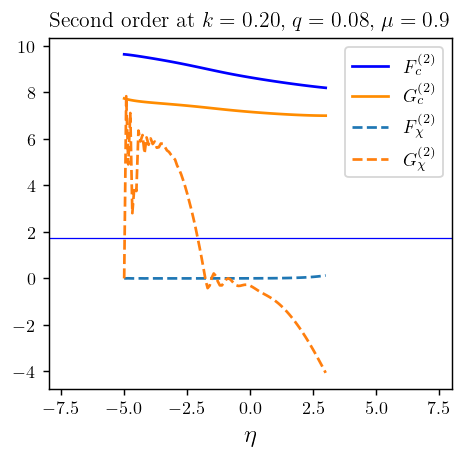

In [24]:
kp=0.2
qp=0.08
mup=0.9
kMq = np.sqrt(kp**2 + qp**2 - 2*kp*qp*mup)
cT12 = (kp*mup-qp)/kMq
# sol=solve_second_order([qp,kMq,cT12], return_timedep=True)
# solF3=solve_F3_for_k([kp,qp,mup], return_timedep=True)

plt.figure(figsize=(4,3.5), dpi=130)
plt.plot(fullt, sol[:,0], 'b', label=r'$F_c^{(2)}$')
plt.plot(fullt, sol[:,1], 'darkorange', label=r'$G_c^{(2)}$')
# plt.plot(fullt, solF3, 'g', label=r'$F_c^{(3)}$')

plt.plot(fullt, sol[:,2], linestyle='--', label=r'$F_\chi^{(2)}$')
plt.plot(fullt, sol[:,3], linestyle='--', label=r'$G_\chi^{(2)}$')

plt.axhline(F2(kp,qp,mup), color='b', linewidth=0.7)
# plt.axhline(F3(kp,qp,mup), color='g', linewidth=0.7)

plt.legend()
plt.xlim([-8,8])

# plt.yscale('log')
plt.title(r'Second order at $k='+'%.2f'%kp+r'$, $q='+'%.2f'%qp+r'$, $\mu='+'%.1f'%mup+r'$')
plt.xlabel(r'$\eta$', fontsize=14)
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/F2_kers_eta.pdf', bbox_inches='tight')

plt.show()

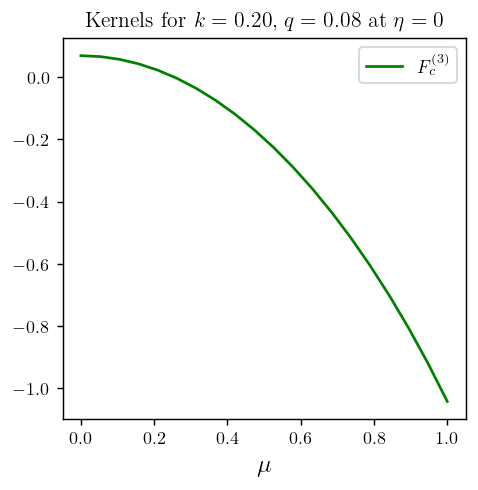

In [24]:
mulist=np.linspace(0,1,20)
Flist=[];Flist_EdS=[]
for mup in mulist:
    kMq = np.sqrt(kp**2 + qp**2 - 2*kp*qp*mup)
    cT12 = (kp*mup-qp)/kMq
    # sol=solve_second_order([qp,kMq,cT12])[0]
    # solF3=solve_F3_for_k([kp,qp,mup])
    # Flist.append([sol,solF3])
    Flist_EdS.append([F2(kp,qp,mup),F3(kp,qp,mup)])
Flist=np.array(Flist);Flist_EdS=np.array(Flist_EdS);
plt.figure(figsize=(4,3.8), dpi=130)
# plt.plot(mulist, Flist[:,0]/Flist_EdS[:,0]-1, 'b', label=r'$F_c^{(2)}$')
plt.plot(mulist, Flist_EdS[:,1], 'g', label=r'$F_c^{(3)}$')

plt.legend()
plt.title(r'Kernels for $k='+'%.2f'%kp+r'$, $q='+'%.2f'%qp+r'$ at $\eta=0$')
# plt.ylabel(r'$F/F_\mathrm{EdS}-1$', fontsize=14)
plt.xlabel(r'$\mu$', fontsize=14)
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/F23_kers_mu.pdf', bbox_inches='tight')

plt.show()

----
### Now 1-loop integration

In [63]:
def P1loop_int(vars, kev):
    q=vars[0]
    mu=vars[1]
    # F3_val=solve_F3_for_k([kev,q,mu])
    F3_val=F3(kev,q,mu)
    P13=6*q*q*F3_val*Plin_int(q)*Plin_int(kev)

    kMq = np.sqrt(kev*kev + q*q - 2*kev*q*mu)
    kPq = np.sqrt(kev*kev + q*q + 2*kev*q*mu)
    P22=0
    if kMq>q:
        cT12 = (kev*mu-q)/kMq
        F2_val=solve_second_order([q,kMq,cT12])[0]
        P22+=2*q*q*F2_val*F2_val*Plin_int(q)*Plin_int(kMq)
    if kPq>q:
        cT12 = -(kev*mu+q)/kPq
        F2_val=solve_second_order([q,kPq,cT12])[0]
        P22+=2*q*q*F2_val*F2_val*Plin_int(q)*Plin_int(kPq)

    return (P13+P22)*4*np.pi/fact
# print(functools.partial(P1loop_int, kev=0.3)([0.2,0.2,0]))
reslist=[]

integ = vegas.Integrator([[1.e-5, 100], [0, 1]],mpi=True, nproc=48)
print('Training', flush=True)
result = integ(functools.partial(P1loop_EdS_int, kev=0.2),neval=10000)
print(f'Training result is {result}')
print('Applying', flush=True)
result = integ(functools.partial(P1loop_int, kev=0.2),neval=500)
print(f'Result with fx={fx} is {result}')


Training
Training result is 507.5(2.1)
Applying
Result with fx=0.3 is 500.8(8.0)


----
heatmap

Integral result: 445.99(37)


-0.00017182812292769828


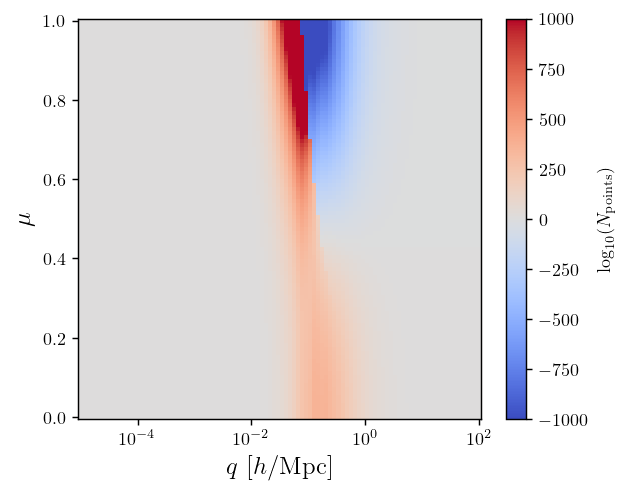

In [48]:
Ngrid=100
heatmap_sampled = np.zeros((Ngrid,Ngrid))
logqgrid=np.linspace(-5,2,Ngrid)
mugrid=np.linspace(0.,1,Ngrid)
for i in range(heatmap_sampled.shape[0]):
    for j in range(heatmap_sampled.shape[1]):
        # print(i,j)
        q=10**(logqgrid[i])
        heatmap_sampled[i, j] = q*P1loop_EdS_int([q,mugrid[j]],kev=0.15)
print(P1loop_EdS_int([10**(logqgrid[-1]),0.5],kev=0.15))
plt.figure(figsize=(5,4), dpi=130)
X, Y = np.meshgrid(10**logqgrid, mugrid)
plt.pcolormesh(X, Y, heatmap_sampled.T, cmap='coolwarm', vmax=1000, vmin=-1000)
plt.colorbar(label=r'$\log_{10}(N_\mathrm{points})$')
plt.xlabel(r"$q$ [$h/\mathrm{Mpc}$]", fontsize=14)
plt.ylabel(r'$\mu$', fontsize=14)
plt.xscale('log')

plt.show()

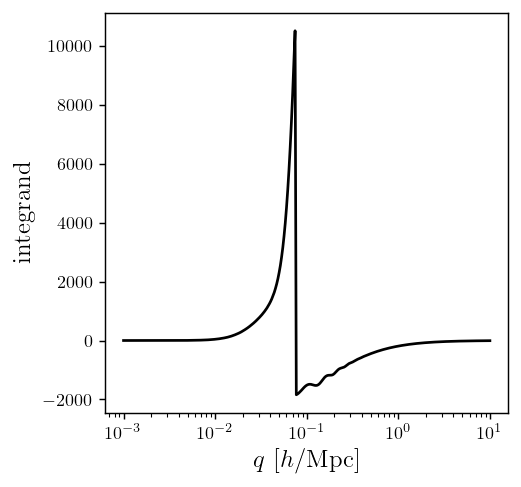

In [80]:
logqgrid=np.linspace(-3,1,300)
integrandlist=[]
for logq in logqgrid:
    integrandlist.append(10**logq*P1loop_EdS_int([10**logq,1],kev=0.15))
plt.figure(figsize=(4,4), dpi=130)

plt.plot(10**logqgrid,integrandlist, 'k')
plt.xlabel(r"$q$ [$h/\mathrm{Mpc}$]", fontsize=14)
plt.ylabel(r'integrand', fontsize=14)
plt.xscale('log')
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/integrand-EdS-mu1p0.pdf', bbox_inches='tight')
plt.show()

In [18]:
integ = vegas.Integrator([[1.e-5, 100], [0, 1.]],mpi=True, nproc=48)
result = integ(functools.partial(P1loop_EdS_int, kev=0.15),nitn=40,neval=500)
print(f'Integral result: {result}')
# Retrieve points and weights from the integrator
random_data = list(integ.random())
points = np.array([data[0] for data in random_data])
weights = np.array([data[1] for data in random_data])
print(points.shape)

Integral result: 444.2(4.9)


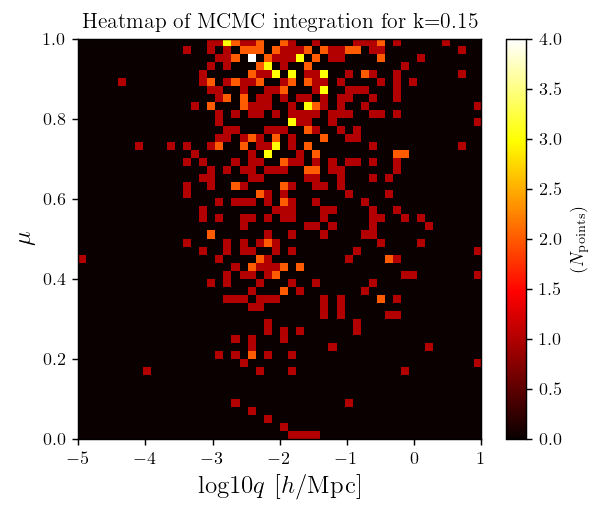

In [2]:
points=np.loadtxt('/home/fverdian/class/soundspeed-scripts/kernels-fullnum/4em/diff-heatmappoints.txt')
supp=np.array([[1.e-5, 10], [0., 1.]])
# Convert points and weights to a heatmap
heatmap, xedges, yedges = np.histogram2d(np.log10(points[:, 0]), points[:, 1], bins=50)
plt.figure(figsize=(5,4), dpi=130)

plt.imshow((heatmap.T+1.e-6), origin='lower', aspect='auto', cmap='hot',extent=[np.log10(supp[0,0]),np.log10(supp[0,1]), supp[1,0],supp[1,1]], vmin=0)
plt.colorbar(label=r'$(N_\mathrm{points})$')
plt.title('Heatmap of MCMC integration for k=0.15')

plt.xlabel(r"log10$q$ [$h/\mathrm{Mpc}$]", fontsize=14)
plt.ylabel(r'$\mu$', fontsize=14)
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/integ-heatmap-EdS.pdf', bbox_inches='tight')

plt.show()

In [22]:
print(np.array(list(integ.random())))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (458, 2) + inhomogeneous part.